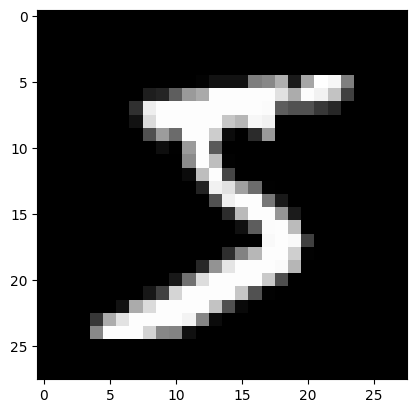

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import edf
import mnist_loader # the file was fixed recently with the name mnist_loader-2,
# I changed the filename back to mnist-loader

train_images, train_labels = mnist_loader.load_mnist(section = 'training', path = 'MNIST')
test_images, test_labels = mnist_loader.load_mnist(section = 'testing', path = 'MNIST')

plt.imshow(train_images[0], cmap='gray', interpolation = 'nearest')
plt.show()

In [17]:
"""we will reshape the 28x28 grayscale images as 
784-dimensional vectors, which will be the network's inputs"""

train_images = train_images.reshape(len(train_images), -1)
test_images = test_images.reshape(len(test_images), -1)

In [18]:
"""we manually set the number of input features (784)
and number of classes (10) which will be used to
define the model"""

nInputs = 784 # each image (first input in the layer 0) has 784 features
nLabels = 10 # number of total unique classes


"""below, MLPparams is an EDF ParameterPackage whose
purpose is to define and store the parameters of the model,
while MLPgraph is a function that implements the model's
forward pass -- in this case, just a 1-hidden layer MLP"""

class MLPparams(edf.ParameterPackage):
    def __init__(self, nInputs, nHiddens, nLabels):
        # rmb: for one image training example only
        # rmb: just one hidden layer which is the output layer
        # 1 input layer (784x1), hidden layer (64x1), 1 output (10x1)

        # random but controlled variance weights and biases 
        # nInputs = 784, nHiddens = 64
        # weights from input-hidden layer: (784, 64)
        # biases from input-hidden layer: (64, )
        self.first = edf.AffineParams(nInputs, nHiddens)

        # nHidden = sth, nOutputs = 10
        # weights from hidden-output layer: (64, 10)
        # biases from hidden-output layer: (10, )
        self.last = edf.AffineParams(nHiddens, nLabels)

        # rmb: both self.first and self.last are values of Affine Params and also
        # Param classes, now become values for MLP Params.
        
def MLPsigmoidgraph(Phi, x):
    # feed forward until prediction

    # computed node for the hidden layer given its params and input x (layer 0)
    h = edf.Sigmoid(edf.Affine(Phi.first, x))

    # computed node for the output layer given its params and input from 
    # previous hidden layer
    return edf.Softmax(edf.Affine(Phi.last, h))


"""we then construct a MLP with 64 hidden units"""

np.random.seed(1234)
edf.clear_compgraph()

# instanciate the inputs x and y as Input class
# note that these numbers are dynamically changed along the fwd
xnode = edf.Input()  # Placeholder for input data (batch)
ynode = edf.Input()  # Placeholder for true labels (batch)

nHiddens = 64 # given and can be tuned

# collect weights and biases for Phi which is a list
Phi = MLPparams(nInputs, nHiddens, nLabels)

# create the graph for the network (forward pass)
probnode = MLPsigmoidgraph(Phi, xnode)  
# MLP output (probabilities, but not the actual values yet, aka probnode.value still empty

# done with feed fwd, get the initial
lossnode = edf.LogLoss(probnode, ynode)
# same, lossnode is still empty

# basically, only Phi is initialized with actual numbers

In [19]:
# print(Phi) # MLPparams object
# print(Phi.first) # AffineParams object
# print(Phi.first.w) # Parameter object
# print(Phi.first.w.value) # get the value
# print(Phi.last.w.value) # get the value

In [20]:
"""the following functions are used to train the network.
training is done by iterating over mini-batches of size 'batch_size'
and updating the model's parameters with SGD"""


# run one single epoch:
def run_epoch(batch_size, data, labels, xnode, ynode, probnode, lossnode=None):
    num_samples = len(data)
    total_err = 0.0
    num_batches = num_samples // batch_size

    # process each batch
    for i in range(num_batches):

        # start of each corresponding batch and end of it
        start, end = i*batch_size, (i+1)*batch_size

        # get x and y data (true labels)
        xnode.value = train_images[start:end]
        ynode.value = train_labels[start:end]

        # perform feed fwd for all CompNodes (global)
        # CompNodes is a global list which has all the computed nodes like weighted
        # sums, activations outputs - each of which has its own forward function
        edf.Forward()

        # np.argmax(probnode.value, axis=1) tries to get the max for each training example
        # in the batch. example: probnode = (batch_size, nClasses) = (2,4)
        # probnode = [[.1, .2, .3, .8], [.2, .7, .4, .5]]
        # np.argmax(probnode.value, axis=1) => index corresponded = [3, 1] for this batch of 2
        # then compare them to ynode which is (batchsize, ) = (2, ) = [3, 0] 
        # or actually true labels
        total_err += np.sum(np.not_equal(np.argmax(probnode.value, axis=1), 
                                        ynode.value))

        # in this batch, starting from the initial lossnode specified outside
        # rmb: lossnode is a placeholder node used to calculate the loss between
        # true y and probnode.value
        if lossnode:
            edf.Backward(lossnode) 
            edf.SGD()

        if i>0 and i%400 == 0: # every 400 batches, print
            print ("\t Batch {}/{}".format(i, num_batches))

    return 100*total_err/num_samples


def train(num_epochs, batch_size, xnode, ynode, probnode, lossnode):
    train_err_log = []
    test_err_log = []

    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch+1, num_epochs))

        train_err = run_epoch(batch_size, train_images, train_labels, xnode, ynode, probnode, lossnode)
        train_err_log.append(train_err)
        print ("\t Training Error {:.2f} %".format(train_err))

        test_err = run_epoch(len(test_images), test_images, test_labels, xnode, ynode, probnode)
        test_err_log.append(test_err)
        print ("\t Test Error {:.2f} %".format(test_err))
        
    return train_err_log, test_err_log

In [21]:
"""now, we are ready to train the network. we can choose SGD's learning rate
by changing edf.learning_rate, which we will set as 0.5 for now."""

num_epochs = 10
batch_size = 64
edf.learning_rate = 0.5
train_err_log, test_err_log = train(num_epochs, batch_size, xnode, ynode, probnode, lossnode)

Epoch: 1/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 11.51 %
	 Test Error 7.89 %
Epoch: 2/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 6.37 %
	 Test Error 5.77 %
Epoch: 3/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 5.00 %
	 Test Error 4.56 %
Epoch: 4/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.10 %
	 Test Error 3.78 %
Epoch: 5/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.49 %
	 Test Error 3.25 %
Epoch: 6/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.09 %
	 Test Error 2.85 %
Epoch: 7/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.78 %
	 Test Error 2.60 %
Epoch: 8/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.49 %
	 Test Error 2.35 %
Epoch: 9/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.24 %
	 Test Error 2.20 %
Epoch: 10/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.01 %
	 Test Error 2.06 %


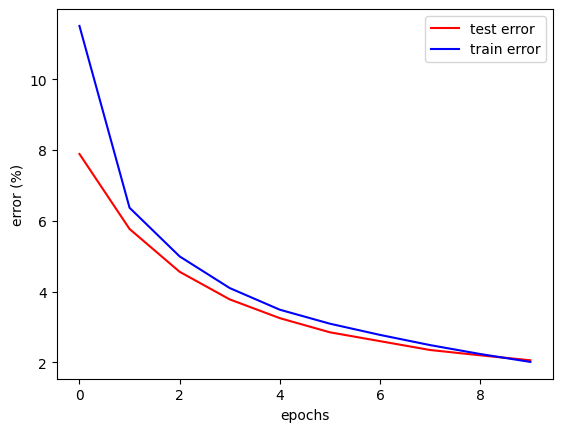

<Figure size 640x480 with 0 Axes>

In [22]:
"""we can then plot the error per epoch on the training and test data"""

plt.xlabel("epochs")
plt.ylabel("error (%)")
plt.plot(np.arange(len(test_err_log)), test_err_log, color='red')
plt.plot(np.arange(len(train_err_log)), train_err_log, color='blue')
plt.legend(['test error', 'train error'], loc='upper right')
plt.show()
plt.clf()

In [23]:
"""next, you have to implement a ReLU activation function ReLU(x) = max(0,x).
implement the forward and backward methods of the following class. use the
provided EDF source code to understand what each method should do. note that
since ReLU has no parameters, it might be helpful to base your implementation
on how the Sigmoid EDF CompNode is implemented."""

class ReLU(edf.CompNode):
    # let's assume CompNode is a
    def __init__(self, x):
        edf.CompNodes.append(self)
        self.x = x

    def forward(self):
        # implementation goes here

        # value of the activation output given this x input
        # similar to Sigmoid class in edf.py, bound the x.value to avoid 
        # numerical warning for 10 layers

        bounded = np.minimum(10, self.x.value)
        self.value = np.where(bounded > 0, bounded, 0)

        #self.value = np.where(self.x.value > 0, self.x.value, 0)

    def backward(self):
        # implementation goes here
        
        # self.value = a, self.grad = dL/da
        # a = max(0, x) => if x>0, a=x; otherwise a=0
        # dL/dx = dL/da * da/dx = self.grad * 1 if x > 0
        # dL/dx = dL/da * da/dx = self.grad * 0 if x <= 0
        # gradient of ReLU is 1 for input (x) greater than 0, and 0 otherwise.
        dadx = np.where(self.value > 0, 1, 0)
        dLdx = self.grad * dadx
        self.x.addgrad(dLdx)


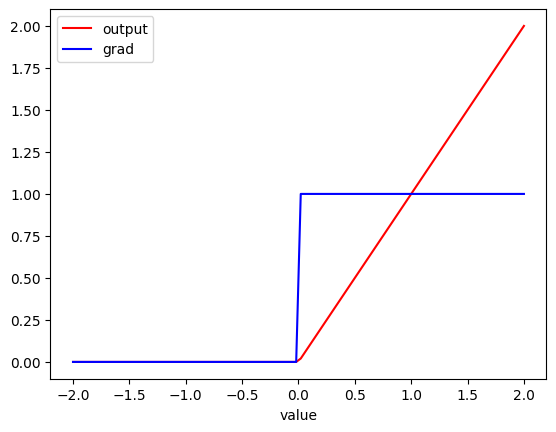

<Figure size 640x480 with 0 Axes>

In [24]:
"""the code below will plot the output and gradients computed by your
implementation of the ReLU component above. check if the plots match
ReLU(x) and dReLU/dx(x) as a sanity test of your implementation."""

values = np.linspace(-2,2,100)
edf.clear_compgraph()
param = edf.Parameter(values[None, :])
output = ReLU(param)

edf.Forward()
edf.Backward(output)

plt.xlabel("value")
plt.plot(values, output.value[0], color='red')
plt.plot(values, param.grad[0], color='blue')
plt.legend(['output', 'grad'], loc='upper left')
plt.show()
plt.clf()

In [25]:
"""now, train the same network as before but with a ReLU activation
in the hidden layer instead of a Sigmoid."""

def MLPrelugraph(Phi, x):
    h = ReLU(edf.Affine(Phi.first, x))
    return edf.Softmax(edf.Affine(Phi.last, h))

np.random.seed(1234)
edf.clear_compgraph()
xnode = edf.Input()
ynode = edf.Input()
nHiddens = 64
Phi = MLPparams(nInputs, nHiddens, nLabels)
probnode = MLPrelugraph(Phi, xnode)
lossnode = edf.LogLoss(probnode, ynode)

In [26]:
num_epochs = 10
batch_size = 64
edf.learning_rate = 0.5
train_err_log, test_err_log = train(num_epochs, batch_size, xnode, ynode, probnode, lossnode)

Epoch: 1/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 7.98 %
	 Test Error 6.81 %
Epoch: 2/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.70 %
	 Test Error 4.17 %
Epoch: 3/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.73 %
	 Test Error 2.78 %
Epoch: 4/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.25 %
	 Test Error 2.38 %
Epoch: 5/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.80 %
	 Test Error 2.17 %
Epoch: 6/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.59 %
	 Test Error 1.97 %
Epoch: 7/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.28 %
	 Test Error 2.07 %
Epoch: 8/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.13 %
	 Test Error 1.75 %
Epoch: 9/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 0.96 %
	 Test Error 1.53 %
Epoch: 10/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 0.86 %
	 Test Error 1.62 %


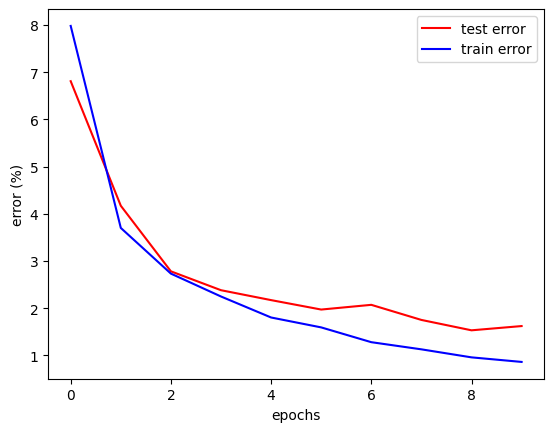

<Figure size 640x480 with 0 Axes>

In [27]:
plt.xlabel("epochs")
plt.ylabel("error (%)")
plt.plot(np.arange(len(test_err_log)), test_err_log, color='red')
plt.plot(np.arange(len(train_err_log)), train_err_log, color='blue')
plt.legend(['test error', 'train error'], loc='upper right')
plt.show()
plt.clf()

In [28]:
"""now, implement the Tanh activation function by filling the missing
code in the forward and backward methods below. it might be helpful to derive
a relationship between Tanh and Sigmoid so that you can re-use parts of 
EDF's Sigmoid code."""

class Tanh(edf.CompNode):
    def __init__(self, x):
        edf.CompNodes.append(self)
        self.x = x

    def forward(self):
        # implementation goes here
        # self.value = np.tanh(self.x.value)
        self.temp_param = edf.Parameter(2 * self.x.value)
        self.sigmoid_2x = edf.Sigmoid(self.temp_param)
        self.sigmoid_2x.forward()
        self.value = 2 * self.sigmoid_2x.value - 1

    def backward(self):
        # implementation goes here
        # get the gradients given chain rules
        dL_dtanh = self.grad
        dtanh_dsigmoid2x = 2
        dsigmoid2x_dx = self.sigmoid_2x.value * (1 - self.sigmoid_2x.value) * 2 # the last 2 is from d(2x)/dx in dsigmoid(2x)/d(2x) * d(2x)/dx
        dLdx = dL_dtanh * dtanh_dsigmoid2x * dsigmoid2x_dx

        # add the gradient to x
        self.x.addgrad(dLdx)

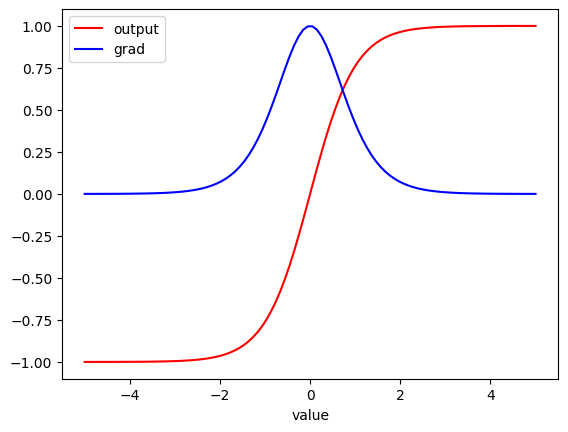

<Figure size 640x480 with 0 Axes>

In [62]:
"""again, make sure that the output and gradients plotted below are correct."""

values = np.linspace(-5,5,100)
edf.clear_compgraph()
param = edf.Parameter(values[None, :])
output = Tanh(param)

edf.Forward()
edf.Backward(output)

plt.xlabel("value")
plt.plot(values, output.value[0], color='red')
plt.plot(values, param.grad[0], color='blue')
plt.legend(['output', 'grad'], loc='upper left')
plt.show()
plt.clf()

In [63]:
"""you can then train a network with a Tanh activation function instead
of Sigmoid/ReLU."""

def MLPtanhgraph(Phi, x):
    h = Tanh(edf.Affine(Phi.first, x))
    return edf.Softmax(edf.Affine(Phi.last, h))

np.random.seed(1234)
edf.clear_compgraph()
xnode = edf.Input()
ynode = edf.Input()
nHiddens = 64
Phi = MLPparams(nInputs, nHiddens, nLabels)
probnode = MLPtanhgraph(Phi, xnode)
lossnode = edf.LogLoss(probnode, ynode)

In [64]:
num_epochs = 10
batch_size = 64
edf.learning_rate = 0.5
train_err_log, test_err_log = train(num_epochs, batch_size, xnode, ynode, probnode, lossnode)

Epoch: 1/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 8.29 %
	 Test Error 6.01 %
Epoch: 2/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.21 %
	 Test Error 4.13 %
Epoch: 3/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.05 %
	 Test Error 2.93 %
Epoch: 4/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.38 %
	 Test Error 2.26 %
Epoch: 5/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.95 %
	 Test Error 1.82 %
Epoch: 6/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.60 %
	 Test Error 1.60 %
Epoch: 7/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.31 %
	 Test Error 1.41 %
Epoch: 8/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.07 %
	 Test Error 1.28 %
Epoch: 9/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 0.84 %
	 Test Error 1.20 %
Epoch: 10/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 0.66 %
	 Test Error 1.21 %


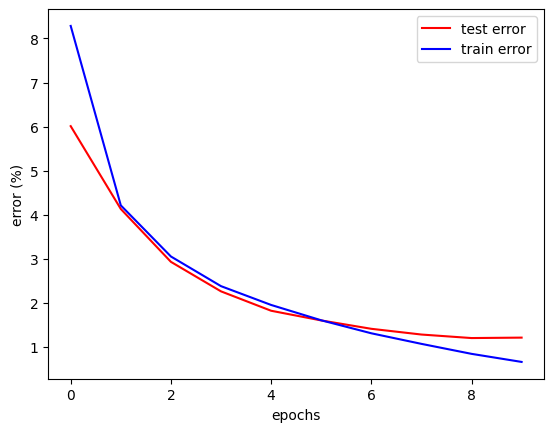

<Figure size 640x480 with 0 Axes>

In [65]:
plt.xlabel("epochs")
plt.ylabel("error (%)")
plt.plot(np.arange(len(test_err_log)), test_err_log, color='red')
plt.plot(np.arange(len(train_err_log)), train_err_log, color='blue')
plt.legend(['test error', 'train error'], loc='upper right')
plt.show()
plt.clf()

In [33]:
"""next, let's check how changing the learning rate affects
the model's train and test error. you should implement a way
to collect the network's final train/test errors for each of
the learning rates in the array below. you should do this for
MLPs with sigmoid and relu activations, and select the best
learning rate for each of the two networks (w/ sigmoid 
and w/ relu activations)"""

"""add code below to train MLPs with sigmoid activations.
your code should populate the arrays train_err_per_lr and
test_err_per_lr, such that they contain the train and test
errors of models trained with each learning rate in the
learning_rates arrays, i.e. train_err_per_lr[1] should contain
the final train error of a sigmoid MLP trained with a learning
rate of 1.0"""

num_epochs = 5
batch_size = 64
learning_rates = [5.0, 1.0, 0.5, 0.1]

train_err_per_lr = []
test_err_per_lr = []

# sigmoid only first as the activation for the hidden layer

# each learning rate => collect the the train train_err_per_lr
# each learning rate => collect the the test test_err_per_lr
# x-axis is the learning rates, y-axis is the error

# implementation goes here

for lr in learning_rates:

    print()
    print(f"Learning rate:  {lr}")

    np.random.seed(1234)
    edf.clear_compgraph()
    xnode = edf.Input()
    ynode = edf.Input()
    nHiddens = 64

    # initialize the Phi and set up the probnode and lossnode as starting point later
    Phi = MLPparams(nInputs, nHiddens, nLabels)
    probnode = MLPsigmoidgraph(Phi, xnode)
    lossnode = edf.LogLoss(probnode, ynode)

    edf.learning_rate = lr
    train_err_log, test_err_log = train(num_epochs, batch_size, xnode, ynode, probnode, lossnode)

    # for each learning rate, save the final error of train and test to the global lists
    train_err_per_lr.append(train_err_log[-1])
    test_err_per_lr.append(test_err_log[-1])


Learning rate:  5.0
Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 12.01 %
	 Test Error 8.75 %
Epoch: 2/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 6.15 %
	 Test Error 6.68 %
Epoch: 3/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 5.12 %
	 Test Error 6.85 %
Epoch: 4/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.62 %
	 Test Error 5.22 %
Epoch: 5/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.10 %
	 Test Error 4.30 %

Learning rate:  1.0
Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 10.08 %
	 Test Error 6.81 %
Epoch: 2/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.96 %
	 Test Error 4.68 %
Epoch: 3/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.71 %
	 Test Error 3.51 %
Epoch: 4/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.98 %
	 Test Error 2.86 %
Epoch: 5/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.51 %
	 Test Error 2.39 %

Learning rate:  0.5
Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 11.51

In [34]:
# implementation goes here

# Here, we first find the index in test_err_per_lr list that gives the minimum value
# or minimum error. Then, use it index to get the corresponding learning rate in the
# learning rates list. We can do this because they are parallel.
best_sigmoid_lr = learning_rates[np.argmin(test_err_per_lr)]
best_sigmoid_lr

1.0

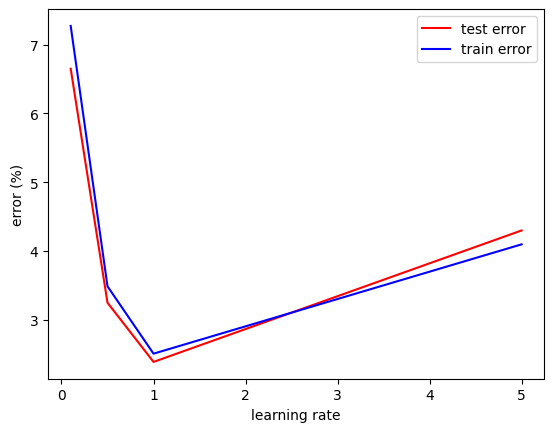

<Figure size 640x480 with 0 Axes>

In [35]:
plt.xlabel("learning rate")
plt.ylabel("error (%)")
plt.plot(learning_rates, test_err_per_lr, color='red')
plt.plot(learning_rates, train_err_per_lr, color='blue')
plt.legend(['test error', 'train error'], loc='upper right')
plt.show()
plt.clf()

In [36]:
"""now, repeat the experiment above but with a MLP with
a ReLU activation functions in the hidden layer"""

train_err_per_lr = []
test_err_per_lr = []

# implementation goes here

# now, ReLU as the activation for the hidden layer
for lr in learning_rates:

    print()
    print(f"Learning rate:  {lr}")

    np.random.seed(1234)
    edf.clear_compgraph()
    xnode = edf.Input()
    ynode = edf.Input()
    nHiddens = 64

    # initialize the Phi and set up the probnode and lossnode as starting point later
    Phi = MLPparams(nInputs, nHiddens, nLabels)
    probnode = MLPrelugraph(Phi, xnode)
    lossnode = edf.LogLoss(probnode, ynode)

    edf.learning_rate = lr
    train_err_log, test_err_log = train(num_epochs, batch_size, xnode, ynode, probnode, lossnode)

    # for each learning rate, save the final error of train and test to the global lists
    train_err_per_lr.append(train_err_log[-1])
    test_err_per_lr.append(test_err_log[-1])


Learning rate:  5.0
Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 90.17 %
	 Test Error 90.20 %
Epoch: 2/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 90.27 %
	 Test Error 90.20 %
Epoch: 3/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 90.27 %
	 Test Error 90.20 %
Epoch: 4/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 90.27 %
	 Test Error 90.20 %
Epoch: 5/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 90.27 %
	 Test Error 90.20 %

Learning rate:  1.0
Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 14.22 %
	 Test Error 10.53 %
Epoch: 2/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 6.84 %
	 Test Error 10.60 %
Epoch: 3/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 5.89 %
	 Test Error 7.24 %
Epoch: 4/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 5.34 %
	 Test Error 6.61 %
Epoch: 5/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.91 %
	 Test Error 5.98 %

Learning rate:  0.5
Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training 

In [37]:
# implementation goes here
best_relu_lr = learning_rates[np.argmin(test_err_per_lr)]
best_relu_lr

0.5

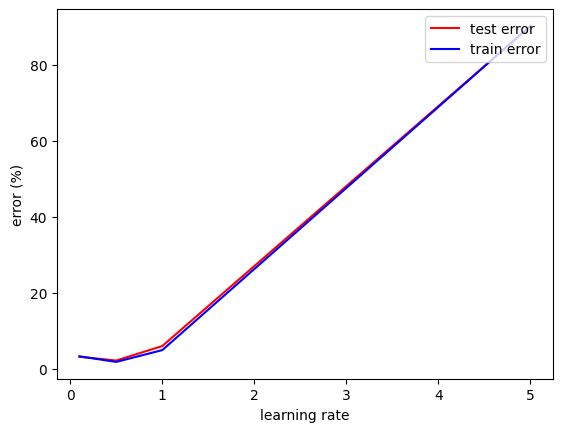

<Figure size 640x480 with 0 Axes>

In [38]:
plt.xlabel("learning rate")
plt.ylabel("error (%)")
plt.plot(learning_rates, test_err_per_lr, color='red')
plt.plot(learning_rates, train_err_per_lr, color='blue')
plt.legend(['test error', 'train error'], loc='upper right')
plt.show()
plt.clf()

In [39]:
"""finally, we will check how the number of hidden layers affects
the model's performance. start by re-implementing MLPparams such that
it supports multiple layers (note the new nLayers argument). each of the
nLayers-1 hidden layers should have nHiddens neurons."""


class MLPparams(edf.ParameterPackage):
    def __init__(self, nInputs, nHiddens, nLabels, nLayers):
        # implementation goes here
        
        self.first = edf.AffineParams(nInputs, nHiddens)

        self.hidden = []
        for _ in range(nLayers-1):
            # note: no. params = no. layers - 1
            # create AffineParams instance for each hidden layer
            # and add them to self.hidden
            # since they all have the same nHiddens neurons
            self.hidden.append(edf.AffineParams(nHiddens, nHiddens))

        self.last = edf.AffineParams(nHiddens, nLabels)


"""you should also re-implement MLPsigmoidgraph and MLPrelugraph
so that they both have support for multiple layers, following your
re-implementation of MLPparams above."""
    
def MLPsigmoidgraph(Phi, x):
    # implementation goes here
    current_layer_h = edf.Sigmoid(edf.Affine(Phi.first, x))
    for next_layer_phi in Phi.hidden:
        current_layer_h = edf.Sigmoid(edf.Affine(next_layer_phi, current_layer_h))
    last_layer_prediction = edf.Softmax(edf.Affine(Phi.last, current_layer_h))

    return last_layer_prediction


def MLPrelugraph(Phi, x):
    # implementation goes here
    current_layer_h = ReLU(edf.Affine(Phi.first, x))
    for next_layer_phi in Phi.hidden:
        current_layer_h = ReLU(edf.Affine(next_layer_phi, current_layer_h))
    last_layer_prediction = edf.Softmax(edf.Affine(Phi.last, current_layer_h))

    return last_layer_prediction

In [40]:
"""similarly to the exploration with different learning rates,
you will see how the depth of the network affects its performance,
first for a sigmoid network. fill the missing code to populate
train_err_per_depth and test_err_per_depth accordingly"""

edf.learning_rate = best_sigmoid_lr
num_epochs = 5
batch_size = 64
num_layers = [2, 4, 6]

train_err_per_depth = []
test_err_per_depth = []

# implementation goes here

for l in num_layers:
    
    print()
    print(f"Number of hidden layers:  {l}")
    
    np.random.seed(1234)
    edf.clear_compgraph()
    xnode = edf.Input()
    ynode = edf.Input()
    nHiddens = 64

    # initialize the Phi and set up the probnode and lossnode as starting point later
    Phi = MLPparams(nInputs, nHiddens, nLabels, nLayers=l) # change different nLayers
    probnode = MLPsigmoidgraph(Phi, xnode)
    lossnode = edf.LogLoss(probnode, ynode)

    train_err_log, test_err_log = train(num_epochs, batch_size, xnode, ynode, probnode, lossnode)

    # for each learning rate, save the final error of train and test to the global lists
    train_err_per_depth.append(train_err_log[-1])
    test_err_per_depth.append(test_err_log[-1])


Number of hidden layers:  2
Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 15.71 %
	 Test Error 8.37 %
Epoch: 2/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 5.36 %
	 Test Error 6.06 %
Epoch: 3/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.77 %
	 Test Error 4.58 %
Epoch: 4/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.93 %
	 Test Error 3.66 %
Epoch: 5/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.40 %
	 Test Error 3.22 %

Number of hidden layers:  4
Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 85.73 %
	 Test Error 67.00 %
Epoch: 2/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 31.14 %
	 Test Error 17.53 %
Epoch: 3/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 8.18 %
	 Test Error 8.24 %
Epoch: 4/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 5.37 %
	 Test Error 5.30 %
Epoch: 5/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.05 %
	 Test Error 4.31 %

Number of hidden layers:  6
Epoch: 1/5
	 Batch 400/937
	 Batch 800

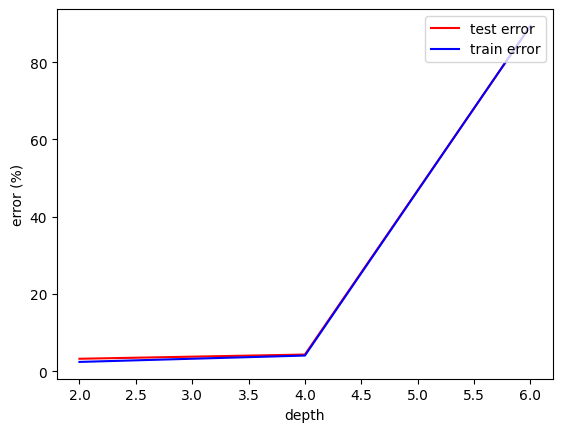

<Figure size 640x480 with 0 Axes>

In [41]:
plt.xlabel("depth")
plt.ylabel("error (%)")
plt.plot(num_layers, test_err_per_depth, color='red')
plt.plot(num_layers, train_err_per_depth, color='blue')
plt.legend(['test error', 'train error'], loc='upper right')
plt.show()
plt.clf()

In [42]:
"""repeat the above experiment but for a ReLU MLP"""

edf.learning_rate = best_relu_lr
num_epochs = 5
batch_size = 64
num_layers = [3, 5, 10]

train_err_per_depth = []
test_err_per_depth = []

# implementation goes here

for l in num_layers:
    
    print()
    print(f"Number of hidden layers:  {l}")
    
    np.random.seed(1234)
    edf.clear_compgraph()
    xnode = edf.Input()
    ynode = edf.Input()
    nHiddens = 64

    # initialize the Phi and set up the probnode and lossnode as starting point later
    Phi = MLPparams(nInputs, nHiddens, nLabels, nLayers=l) # change different nLayers
    probnode = MLPrelugraph(Phi, xnode)
    lossnode = edf.LogLoss(probnode, ynode)

    train_err_log, test_err_log = train(num_epochs, batch_size, xnode, ynode, probnode, lossnode)

    # for each learning rate, save the final error of train and test to the global lists
    train_err_per_depth.append(train_err_log[-1])
    test_err_per_depth.append(test_err_log[-1])


Number of hidden layers:  3
Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 12.38 %
	 Test Error 6.88 %
Epoch: 2/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.60 %
	 Test Error 6.78 %
Epoch: 3/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.45 %
	 Test Error 4.61 %
Epoch: 4/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.84 %
	 Test Error 3.92 %
Epoch: 5/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.73 %
	 Test Error 3.00 %

Number of hidden layers:  5
Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 31.88 %
	 Test Error 11.51 %
Epoch: 2/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 7.45 %
	 Test Error 9.52 %
Epoch: 3/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 5.61 %
	 Test Error 6.70 %
Epoch: 4/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.80 %
	 Test Error 5.13 %
Epoch: 5/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.13 %
	 Test Error 4.96 %

Number of hidden layers:  10
Epoch: 1/5
	 Batch 400/937
	 Batch 800/

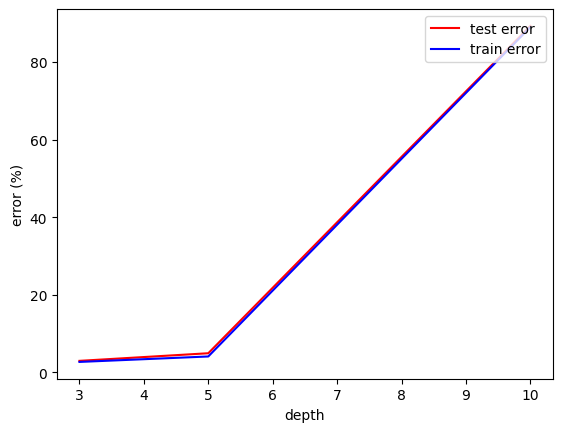

<Figure size 640x480 with 0 Axes>

In [43]:
plt.xlabel("depth")
plt.ylabel("error (%)")
plt.plot(num_layers, test_err_per_depth, color='red')
plt.plot(num_layers, train_err_per_depth, color='blue')
plt.legend(['test error', 'train error'], loc='upper right')
plt.show()
plt.clf()